###  Data Preprocessing Configuration

- Features are standardized using `StandardScaler`
- Quality scores are binned into 3 classes: Low (0), Medium (1), High (2)
- Class imbalance is addressed using **SMOTE oversampling**
- Train/test split is stratified


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, RationalQuadratic
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

from collections import Counter
from src.preprocessing import load_and_preprocess_data


Training set class distribution: Counter({0: 595, 1: 510, 2: 174})
Test set class distribution: Counter({0: 149, 1: 128, 2: 43})


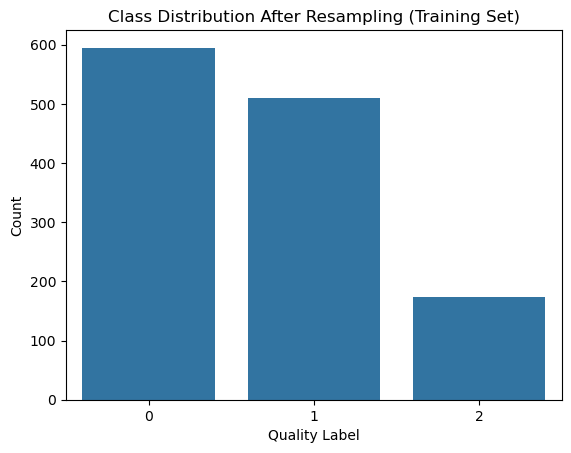

In [5]:
X_train, X_test, y_train, y_test = load_and_preprocess_data()

print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

sns.countplot(x=y_train)
plt.title("Class Distribution After Resampling (Training Set)")
plt.xlabel("Quality Label")
plt.ylabel("Count")
plt.show()


In [6]:
kernels = {
    "RBF": RBF(length_scale=1.0),
    "RationalQuadratic": RationalQuadratic(alpha=1.0, length_scale=1.0),
    "Matern": Matern(length_scale=1.0, nu=1.5),
    "DotProduct": DotProduct()
}

results = []

for name, kernel in kernels.items():
    print(f"Training with {name} kernel...")
    gp = GaussianProcessClassifier(kernel=kernel, random_state=42, max_iter_predict=100)
    gp.fit(X_train, y_train)

    y_pred = gp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    results.append((name, acc, f1))


Training with RBF kernel...


C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Training with RationalQuadratic kernel...


C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Training with Matern kernel...
Training with DotProduct kernel...


In [7]:
df_results = pd.DataFrame(results, columns=["Kernel", "Accuracy", "F1 Score"])
df_results.sort_values("F1 Score", ascending=False).reset_index(drop=True)


,Kernel,Accuracy,F1 Score
0,RationalQuadratic,0.665625,0.612493
1,Matern,0.662500,0.605134
2,DotProduct,0.628125,0.537909
3,RBF,0.634375,0.449607


#### Summary

- Best kernel: **RationalQuadratic**
- Accuracy: **0.666**
- Macro F1 Score: **0.612**
- This kernel handles long-range and short-range variations well, which makes sense for a dataset like wine chemistry.
➡️ Next: Tune `length_scale` and `alpha` hyperparameters for RationalQuadratic.


In [8]:
# Hyperparameter tuning for RationalQuadratic kernel
length_scales = [0.5, 1.0, 1.5, 2.0]
alphas = [0.1, 1.0, 2.0]

tuning_results = []

for ls in length_scales:
    for alpha in alphas:
        kernel = RationalQuadratic(alpha=alpha, length_scale=ls)
        gp = GaussianProcessClassifier(kernel=kernel, random_state=42)
        gp.fit(X_train, y_train)
        y_pred = gp.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        tuning_results.append((ls, alpha, acc, f1))

df_tuned = pd.DataFrame(tuning_results, columns=["Length Scale", "Alpha", "Accuracy", "F1 Score"])
df_tuned.sort_values("F1 Score", ascending=False).reset_index(drop=True)


C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\negia\anaconda3\envs\comp_7703\Lib\site-packages\sklearn\g

,Length Scale,Alpha,Accuracy,F1 Score
0,2.0,0.1,0.675000,0.633691
1,0.5,0.1,0.665625,0.612493
2,1.0,0.1,0.665625,0.612493
3,0.5,1.0,0.665625,0.612493
4,1.5,1.0,0.665625,0.612493
5,1.0,1.0,0.665625,0.612493
6,1.5,0.1,0.665625,0.612493
7,1.0,2.0,0.665625,0.612493
8,2.0,1.0,0.665625,0.612493
9,1.5,2.0,0.665625,0.612493
